In [13]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import time
from datetime import datetime

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# The Influence of Image Resolution
Train model with gray-scaled images for gestures *like*, *top* and *two_up*.
We want to explore the influence of image resolution during training and prediction.
To this end, we define six conditions based on common image resolution for such tasks [1, 2, 3].
We also added a very small image resolution (12x12). Due to the fact that the gesture only takes up a small part of the overall image (1920x1080), adjusting the resolution beyond a certain size is no longer useful. It won't necessarily provide any additional information. Thus (and also because my machine keeps crashing during training otherwise argh), we did not chose any higher resolution than 256x256.

[1] https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015    
[2] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8700246/    
[3] https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network

In [14]:
CONDITIONS = ['like', 'stop', 'two_up']
COLOR_CHANNELS = 1
PATH = '../../gesture_dataset_sample'  # adjust path if necessary
IMG_SIZE_EXPLORATION = [12, 32, 64, 128, 256]

Reading the dataset:   

In [15]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

Load data and definde model:

In [16]:
def preprocess_image(img, size):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (size, size))
    return img_resized

In [17]:
def load_data(size):
    images = [] # stores actual image data
    labels = [] # stores labels (as integer - because this is what our network needs)
    label_names = [] # maps label ints to their actual categories so we can understand predictions later

    # loop over all conditions
    # loop over all files in the condition's directory
    # read the image and corresponding annotation
    # crop image to the region of interest
    # preprocess image
    # store preprocessed image and label in corresponding lists
    for condition in CONDITIONS:
        for filename in os.listdir(f'{PATH}/{condition}'):
            # extract unique ID from file name
            UID = filename.split('.')[0]
            img = cv2.imread(f'{PATH}/{condition}/{filename}')
            
            # get annotation from the dict we loaded earlier
            try:
                annotation = annotations[condition][UID]
            except Exception as e:
                print(e)
                continue
            
            # iterate over all hands annotated in the image
            for i, bbox in enumerate(annotation['bboxes']):
                # annotated bounding boxes are in the range from 0 to 1
                # therefore we have to scale them to the image size
                x1 = int(bbox[0] * img.shape[1])
                y1 = int(bbox[1] * img.shape[0])
                w = int(bbox[2] * img.shape[1])
                h = int(bbox[3] * img.shape[0])
                x2 = x1 + w
                y2 = y1 + h
                
                # crop image to the bounding box and apply pre-processing
                crop = img[y1:y2, x1:x2]
                preprocessed = preprocess_image(crop, size)
                
                # get the annotated hand's label
                # if we have not seen this label yet, add it to the list of labels
                label = annotation['labels'][i]
                if label not in label_names:
                    label_names.append(label)
                
                label_index = label_names.index(label)
                
                images.append(preprocessed)
                labels.append(label_index)
    return images, labels, label_names

In [18]:
def prepare_train_test(images, labels, size):
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_val = np.array(X_val).astype('float32')
    X_val = X_val / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train)
    y_val_one_hot = to_categorical(y_val)
    y_test_one_hot = to_categorical(y_test)

    train_label = y_train_one_hot
    test_label = y_test_one_hot
    val_label = y_val_one_hot

    X_train = X_train.reshape(-1, size, size, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, size, size, COLOR_CHANNELS)
    X_val = X_val.reshape(-1, size, size, COLOR_CHANNELS)
    return X_train, train_label, X_val, val_label, X_test, test_label, y_test

In [19]:
def build_model(label_names, size):
    # variables for hyperparameters
    batch_size = 8
    epochs = 50

    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'LeakyReLU'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    #model.add(RandomFlip('horizontal'))
    #model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(size, size, COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)

    return model, batch_size, epochs, reduce_lr, stop_early


In [20]:
def fit_model(model, batch_size, epochs, reduce_lr, stop_early, X_train, train_labels, X_val, val_labels):
    history = model.fit(
        X_train,
        train_labels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, val_labels),
        callbacks=[reduce_lr, stop_early]
    )
    # model.summary()  # keeps crashing with this uagh, but #params increases
    return history

In [21]:
def train_with_image_resolution(size):
    images, labels, label_names = load_data(size)
    X_train, train_labels, X_val, val_labels, X_test, test_labels, y_test = prepare_train_test(images, labels, size)
    model, batch_size, epochs, reduce_lr, stop_early = build_model(label_names, size)
    return images[0], X_test, test_labels, y_test, label_names, model, fit_model(model, batch_size, epochs, reduce_lr, stop_early, X_train, train_labels, X_val, val_labels)

---
---

In [22]:
# save values for each condition
train_times = []
test_times = []
accuracies = []
losses = []
confusions = []
example_images = []
history_for_size = []

#### Condition 0: 12x12

In [23]:
start_time_train = time.time()
example_img, X_test, test_labels, y_test, label_names, model, hist = train_with_image_resolution(IMG_SIZE_EXPLORATION[0])
train_times.append((time.time() - start_time_train))

losses.append(hist.history['val_loss'])
accuracies.append(hist.history['val_accuracy'])


# let the model make predictions on test data
start_time_test = time.time()
y_predictions = model.predict(X_test)
test_times.append(time.time() - start_time_test)

y_predictions = np.argmax(y_predictions, axis=1)
conf_matrix = confusion_matrix(y_test, y_predictions)
confusions.append((conf_matrix, label_names))


example_images.append(example_img)
history_for_size.append((IMG_SIZE_EXPLORATION[0], hist))

2023-06-11 23:03:56.714347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 23:03:57.191090: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
77/77 [==============================] - 2s 12ms/step - loss: 1.3859 - accuracy: 0.2348 - val_loss: 1.3881 - val_accuracy: 0.2288 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 1s 8ms/step - loss: 1.3711 - accuracy: 0.2594 - val_loss: 1.3821 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 1s 9ms/step - loss: 1.3139 - accuracy: 0.3727 - val_loss: 1.1986 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 1s 8ms/step - loss: 1.1409 - accuracy: 0.4795 - val_loss: 1.0303 - val_accuracy: 0.5163 - lr: 0.0010
Epoch 5/50
77/77 [==============================] - 1s 9ms/step - loss: 1.0340 - accuracy: 0.5452 - val_loss: 1.0714 - val_accuracy: 0.4967 - lr: 0.0010
Epoch 6/50
77/77 [==============================] - 1s 9ms/step - loss: 0.9910 - accuracy: 0.5583 - val_loss: 0.9374 - val_accuracy: 0.7124 - lr: 0.0010
Epoch 7/50
77/77 [==============================] - 1s 8ms/step - loss: 0.9108 - 

#### Condition 1: 32x32

In [24]:
start_time_train = time.time()
example_img, X_test, test_labels, y_test, label_names, model, hist = train_with_image_resolution(IMG_SIZE_EXPLORATION[1])
train_times.append((time.time() - start_time_train))

losses.append(hist.history['val_loss'])
accuracies.append(hist.history['val_accuracy'])


# let the model make predictions on test data
start_time_test = time.time()
y_predictions = model.predict(X_test)
test_times.append(time.time() - start_time_test)

y_predictions = np.argmax(y_predictions, axis=1)
conf_matrix = confusion_matrix(y_test, y_predictions)
confusions.append((conf_matrix, label_names))


example_images.append(example_img)
history_for_size.append((IMG_SIZE_EXPLORATION[1], hist))

Epoch 1/50
77/77 [==============================] - 3s 21ms/step - loss: 1.3893 - accuracy: 0.2496 - val_loss: 1.3940 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 1s 19ms/step - loss: 1.3684 - accuracy: 0.2956 - val_loss: 1.3365 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 1s 19ms/step - loss: 1.2350 - accuracy: 0.3924 - val_loss: 1.1455 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 1s 19ms/step - loss: 0.9939 - accuracy: 0.5599 - val_loss: 0.9038 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 5/50
77/77 [==============================] - 1s 19ms/step - loss: 0.8284 - accuracy: 0.6568 - val_loss: 0.9430 - val_accuracy: 0.6209 - lr: 0.0010
Epoch 6/50
77/77 [==============================] - 1s 19ms/step - loss: 0.6608 - accuracy: 0.7668 - val_loss: 0.7930 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 7/50
77/77 [==============================] - 1s 19ms/step - loss: 0.5

#### Condition 3: 64x64

In [25]:
start_time_train = time.time()
example_img, X_test, test_labels, y_test, label_names, model, hist = train_with_image_resolution(IMG_SIZE_EXPLORATION[2])
train_times.append((time.time() - start_time_train))

losses.append(hist.history['val_loss'])
accuracies.append(hist.history['val_accuracy'])


# let the model make predictions on test data
start_time_test = time.time()
y_predictions = model.predict(X_test)
test_times.append(time.time() - start_time_test)

y_predictions = np.argmax(y_predictions, axis=1)
conf_matrix = confusion_matrix(y_test, y_predictions)
confusions.append((conf_matrix, label_names))


example_images.append(example_img)
history_for_size.append((IMG_SIZE_EXPLORATION[2], hist))

Epoch 1/50
77/77 [==============================] - 6s 59ms/step - loss: 1.3842 - accuracy: 0.2841 - val_loss: 1.3825 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 4s 55ms/step - loss: 1.3693 - accuracy: 0.3153 - val_loss: 1.3432 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 4s 55ms/step - loss: 1.1771 - accuracy: 0.4729 - val_loss: 1.0097 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 4s 56ms/step - loss: 0.9121 - accuracy: 0.6207 - val_loss: 0.7921 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 5/50
77/77 [==============================] - 4s 57ms/step - loss: 0.6840 - accuracy: 0.7652 - val_loss: 0.7513 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 6/50
77/77 [==============================] - 4s 58ms/step - loss: 0.5302 - accuracy: 0.8046 - val_loss: 0.4563 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 7/50
77/77 [==============================] - 4s 58ms/step - loss: 0.3

#### Condition 4: 128x128

In [26]:
start_time_train = time.time()
example_img, X_test, test_labels, y_test, label_names, model, hist = train_with_image_resolution(IMG_SIZE_EXPLORATION[3])
train_times.append((time.time() - start_time_train))

losses.append(hist.history['val_loss'])
accuracies.append(hist.history['val_accuracy'])


# let the model make predictions on test data
start_time_test = time.time()
y_predictions = model.predict(X_test)
test_times.append(time.time() - start_time_test)

y_predictions = np.argmax(y_predictions, axis=1)
conf_matrix = confusion_matrix(y_test, y_predictions)
confusions.append((conf_matrix, label_names))


example_images.append(example_img)
history_for_size.append((IMG_SIZE_EXPLORATION[3], hist))

Epoch 1/50
77/77 [==============================] - 17s 201ms/step - loss: 1.3900 - accuracy: 0.2627 - val_loss: 1.4643 - val_accuracy: 0.2353 - lr: 0.0010
Epoch 2/50
77/77 [==============================] - 16s 210ms/step - loss: 1.3793 - accuracy: 0.3021 - val_loss: 1.3491 - val_accuracy: 0.2288 - lr: 0.0010
Epoch 3/50
77/77 [==============================] - 16s 207ms/step - loss: 1.3228 - accuracy: 0.3859 - val_loss: 1.2008 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 4/50
77/77 [==============================] - 16s 209ms/step - loss: 1.1816 - accuracy: 0.4959 - val_loss: 1.5351 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 5/50
77/77 [==============================] - 16s 209ms/step - loss: 0.9792 - accuracy: 0.6125 - val_loss: 0.9214 - val_accuracy: 0.6209 - lr: 0.0010
Epoch 6/50
77/77 [==============================] - 16s 212ms/step - loss: 0.6608 - accuracy: 0.7635 - val_loss: 0.6174 - val_accuracy: 0.7908 - lr: 0.0010
Epoch 7/50
77/77 [==============================] - 16s 209ms/st

2023-06-11 23:14:48.743702: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2023-06-11 23:14:48.893856: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


3/6 [==============>...............] - ETA: 0s

2023-06-11 23:14:49.047780: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2023-06-11 23:14:49.226770: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


4/6 [===================>..........] - ETA: 0s

2023-06-11 23:14:49.397827: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


6/6 [==============================] - 1s 184ms/step


#### Condition 5: 256x256

In [ ]:
start_time_train = time.time()
example_img, X_test, test_labels, y_test, label_names, model, hist = train_with_image_resolution(IMG_SIZE_EXPLORATION[4])
train_times.append((time.time() - start_time_train))

losses.append(hist.history['val_loss'])
accuracies.append(hist.history['val_accuracy'])


# let the model make predictions on test data
start_time_test = time.time()
y_predictions = model.predict(X_test)
test_times.append(time.time() - start_time_test)

y_predictions = np.argmax(y_predictions, axis=1)
conf_matrix = confusion_matrix(y_test, y_predictions)
confusions.append((conf_matrix, label_names))


example_images.append(example_img)
history_for_size.append((IMG_SIZE_EXPLORATION[4], hist))

Epoch 1/50


---
---

## Results

Show an example image for each resolution:

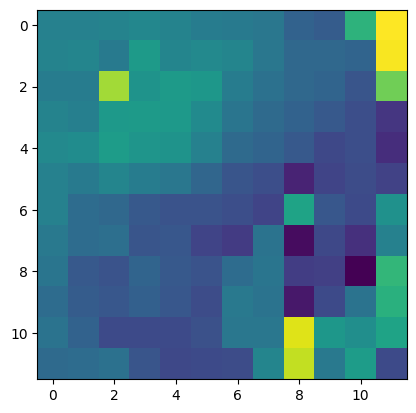

In [39]:
plt.imshow(example_images[0])

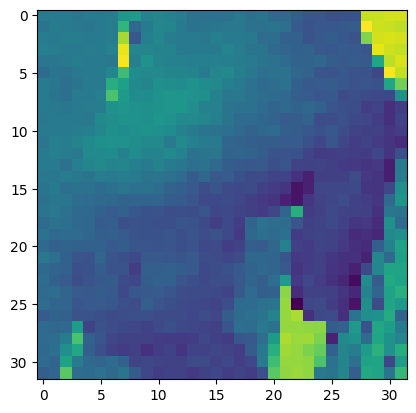

In [40]:
plt.imshow(example_images[1])

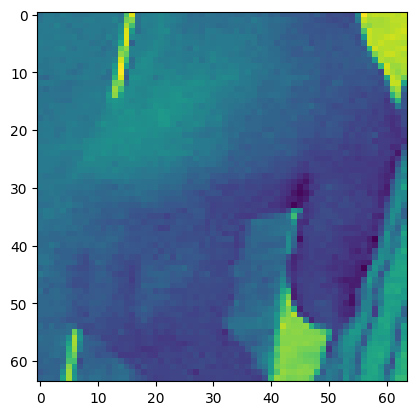

In [41]:
plt.imshow(example_images[2])

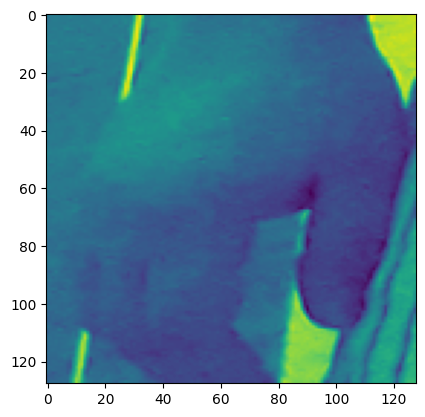

In [42]:
plt.imshow(example_images[3])

In [43]:
plt.imshow(example_images[4])

IndexError: list index out of range

Approximate train and prediction times for each resolution:

In [38]:
for i, train_time in enumerate(train_times):
    t_time = datetime.fromtimestamp(train_time).strftime('%M:%S.%f')
    print(f'Approx. Train Time: {t_time}')
    p_time = datetime.fromtimestamp(test_times[i]).strftime('%M:%S.%f')
    print(f'Approx. Prediction Time: {p_time}')
    print('----------------------------------')

Approx. Train Time: 00:57.054357
Approx. Prediction Time: 00:00.215702
----------------------------------
Approx. Train Time: 01:03.815228
Approx. Prediction Time: 00:00.223351
----------------------------------
Approx. Train Time: 02:14.055927
Approx. Prediction Time: 00:00.392236
----------------------------------
Approx. Train Time: 05:08.082433
Approx. Prediction Time: 00:01.278553
----------------------------------


Validation accuracy and loss for each resolution:

In [37]:
for i, accuracy in enumerate(accuracies):
    print(f'Validation Accuracy: {accuracy[-1]}')
    print(f'Validation Loss: {losses[i][-1]}')
    print('----------------------------------')

Validation Accuracy: 0.8039215803146362
Validation Loss: 0.6737012267112732
----------------------------------
Validation Accuracy: 0.9215686321258545
Validation Loss: 0.25510919094085693
----------------------------------
Validation Accuracy: 0.9542483687400818
Validation Loss: 0.19541621208190918
----------------------------------
Validation Accuracy: 0.9477124214172363
Validation Loss: 0.20630422234535217
----------------------------------


---

### Confusion Matrix one by one

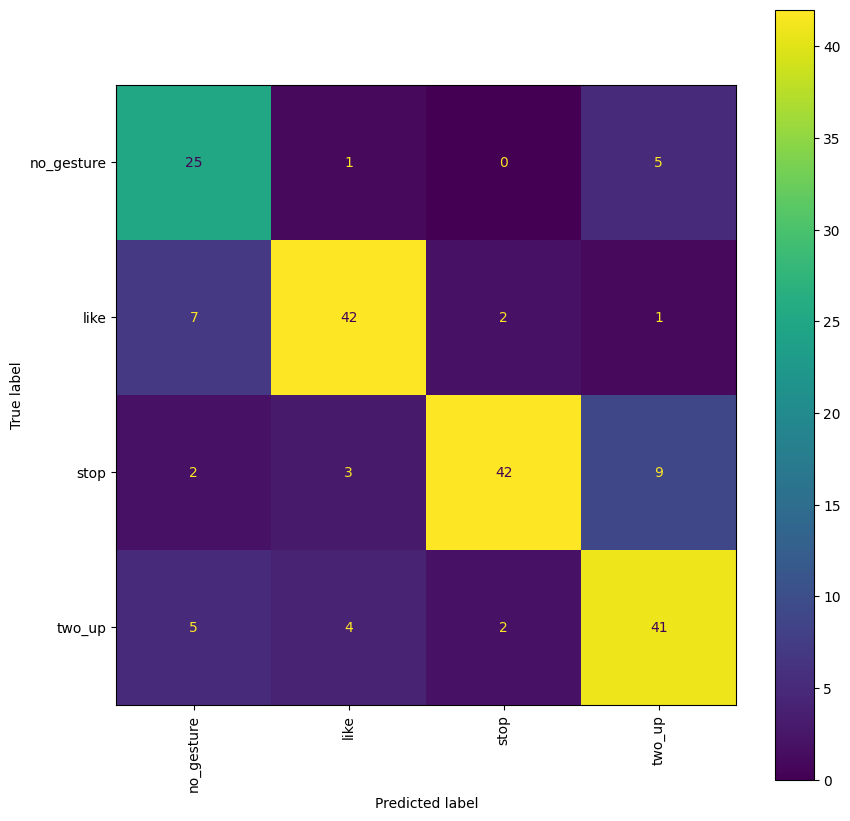

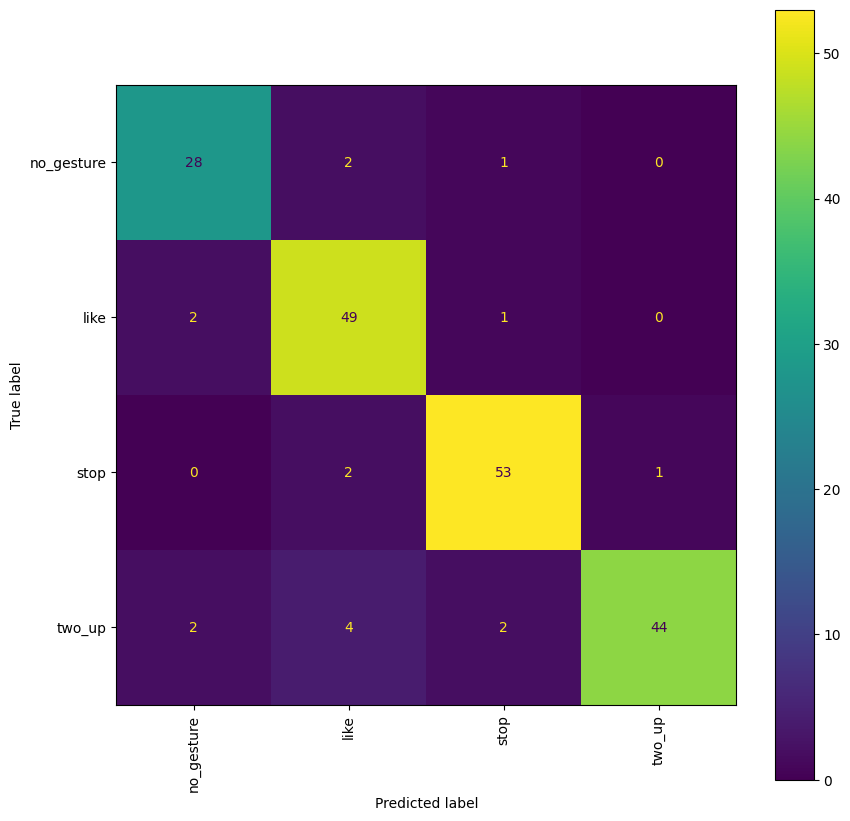

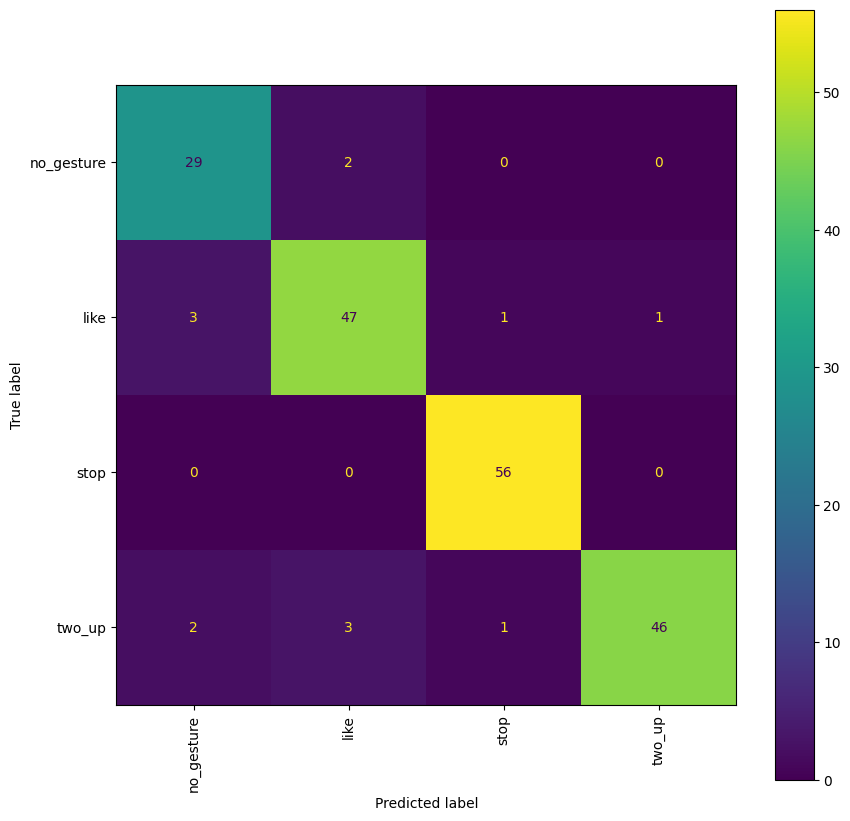

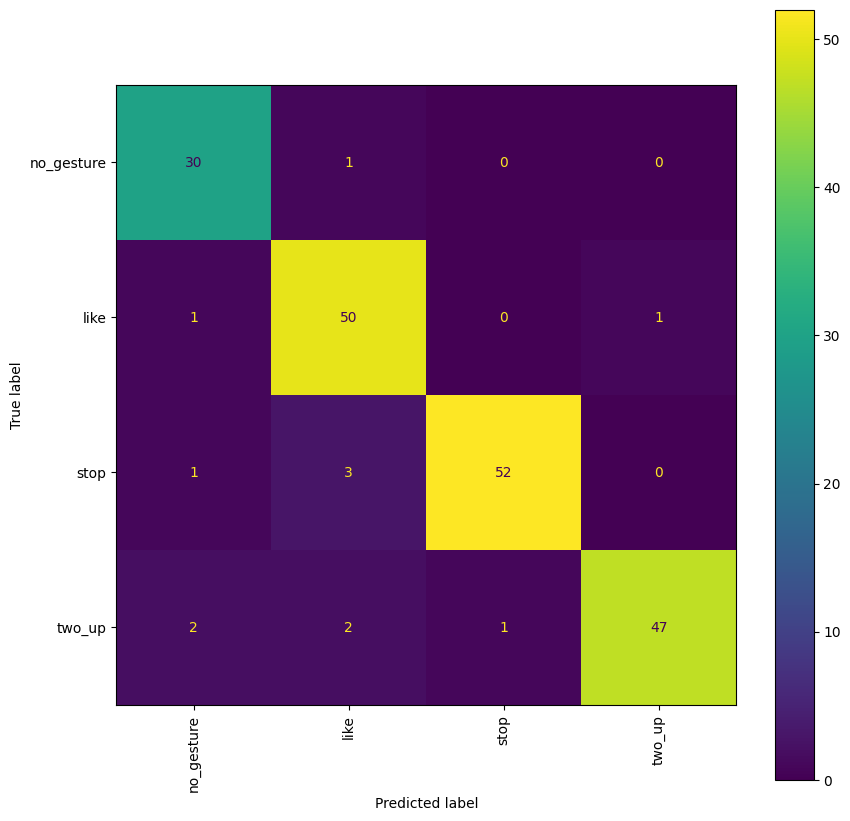

In [31]:
for confusion in confusions:
    martrix = confusion[0]
    labels = confusion[1]

    fig = plt.figure(figsize=(10, 10))
    ConfusionMatrixDisplay(martrix, display_labels=labels).plot(ax=plt.gca())
    plt.xticks(rotation=90, ha='center')
    pass

---

### Histories one by one

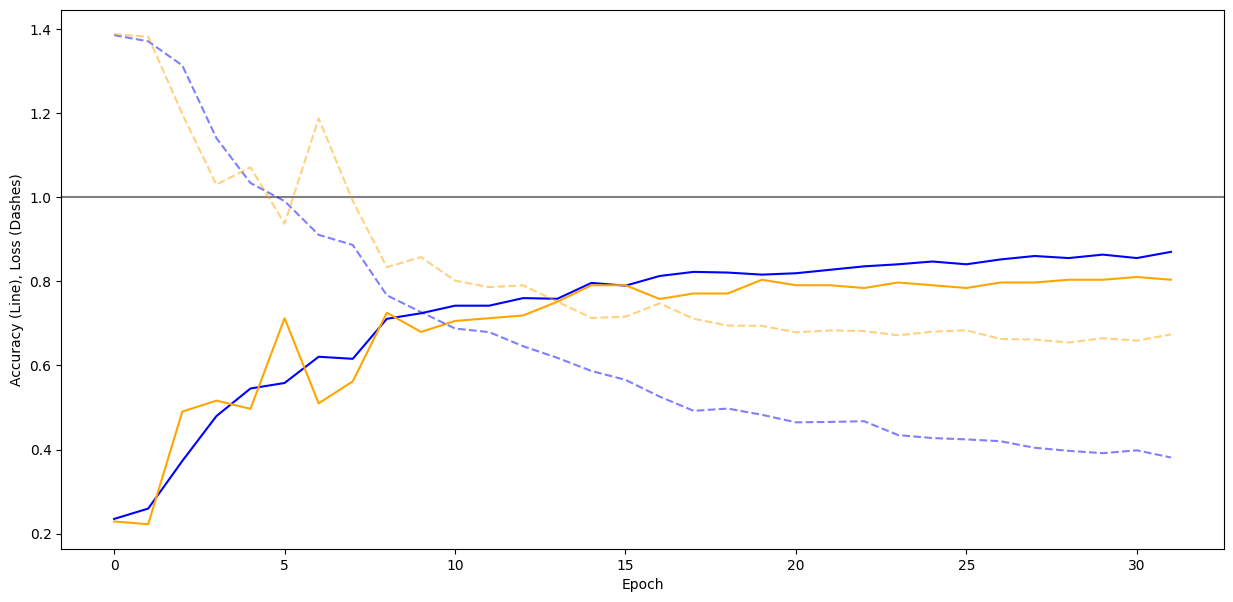

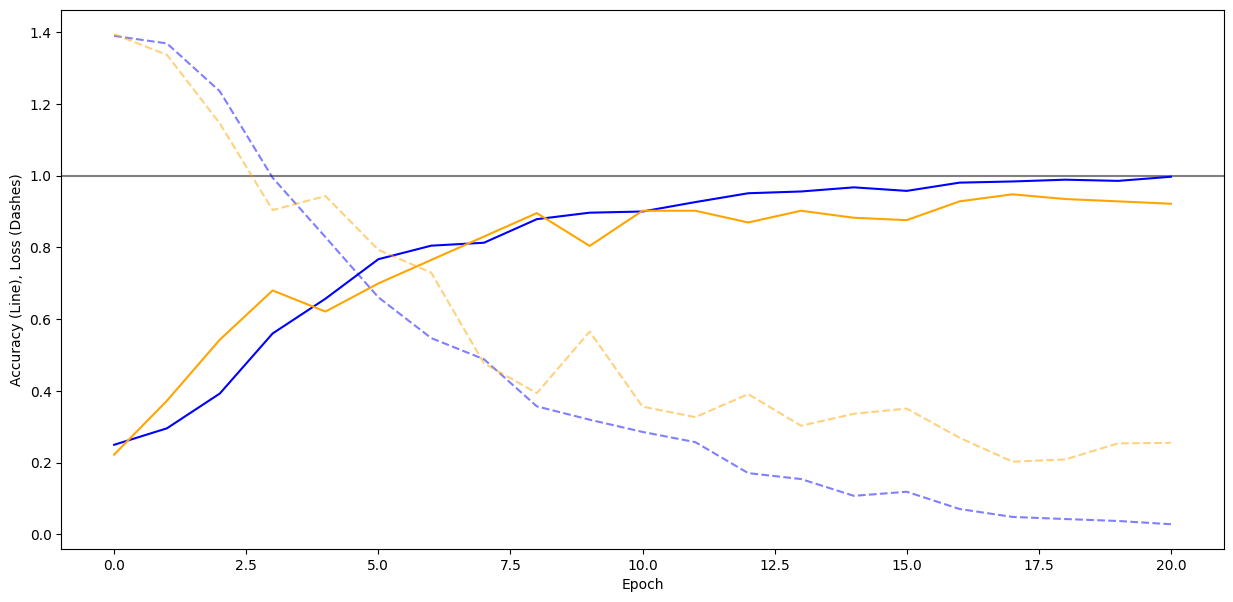

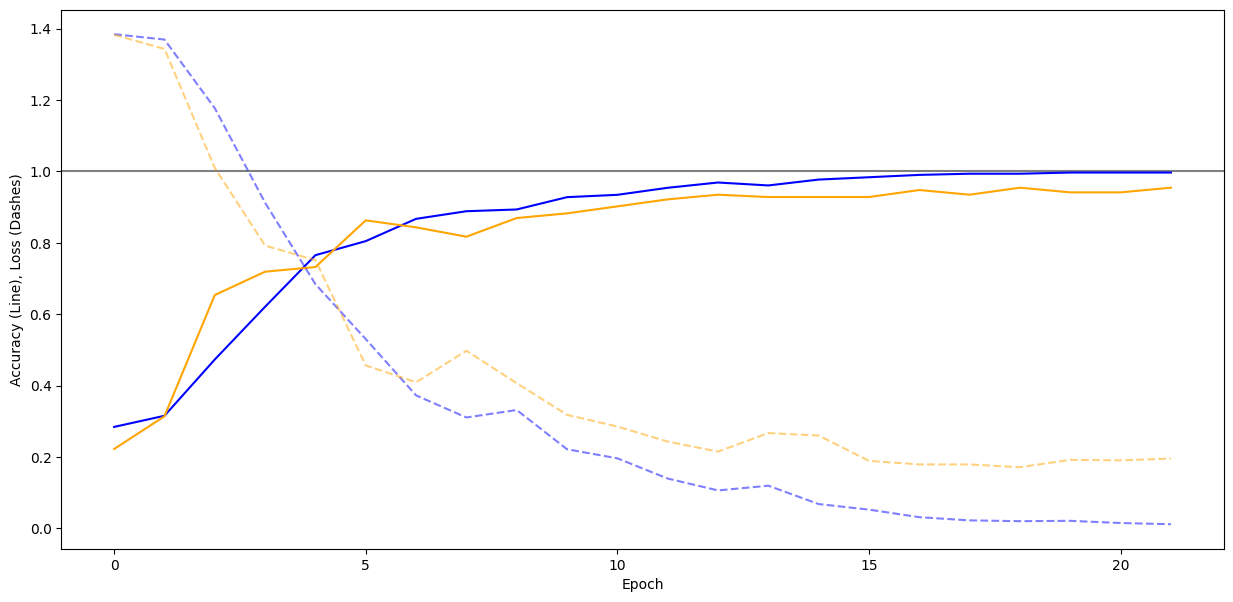

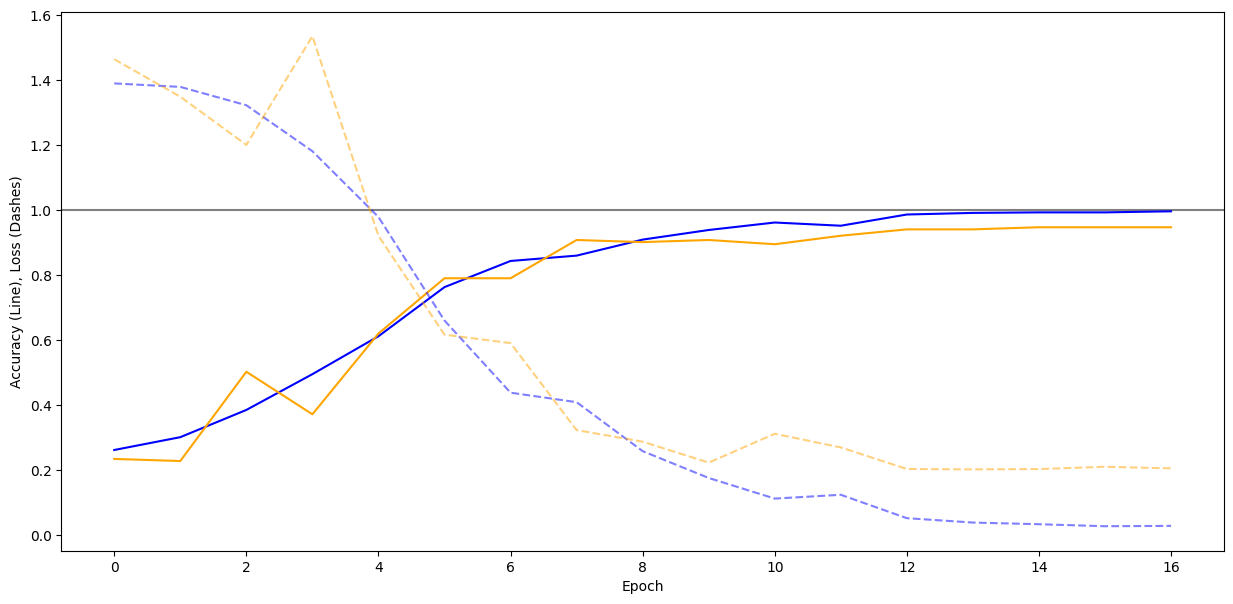

In [32]:
for history in history_for_size:
    size = history[0]
    hist = history[1]

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')
    ax.axhline(1, color='gray')
    
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    accuracy = hist.history['accuracy']
    val_accuracy = hist.history['val_accuracy']

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)
        

**12x12**
- There is a need for running more epochs before accuracy and loss curve cross each other, so the performance increases slow.
- The resulting validation loss value is high (~0.6)
- At the same time, the resulting validation accuracy is just "ok" (~80%)
- Very fast train and prediction time

**32x32**
- Faster increasing accuracy values and decreasing loss values in comparison to *12x12*
- Acceptable validation accuracy and loss, but there is still room for improvement
- Fast train and prediction time

**64x64**
- Almost no difference to *32x32* in validation accuracy and loss
- But: Less epochs required for almost same results

**128x128**
- Better validation accuracy and almost same validation loss in comparison to previous
- And again: Less epochs required 
- Best values so far but very slow in training and prediction

**256x256**
- Accuracy and loss on validation data gets worse with accuracy and loss getting better at the same time.
- Very slow train and prediction time


### Histories in comparison

In [33]:
from plot_keras_history import plot_history

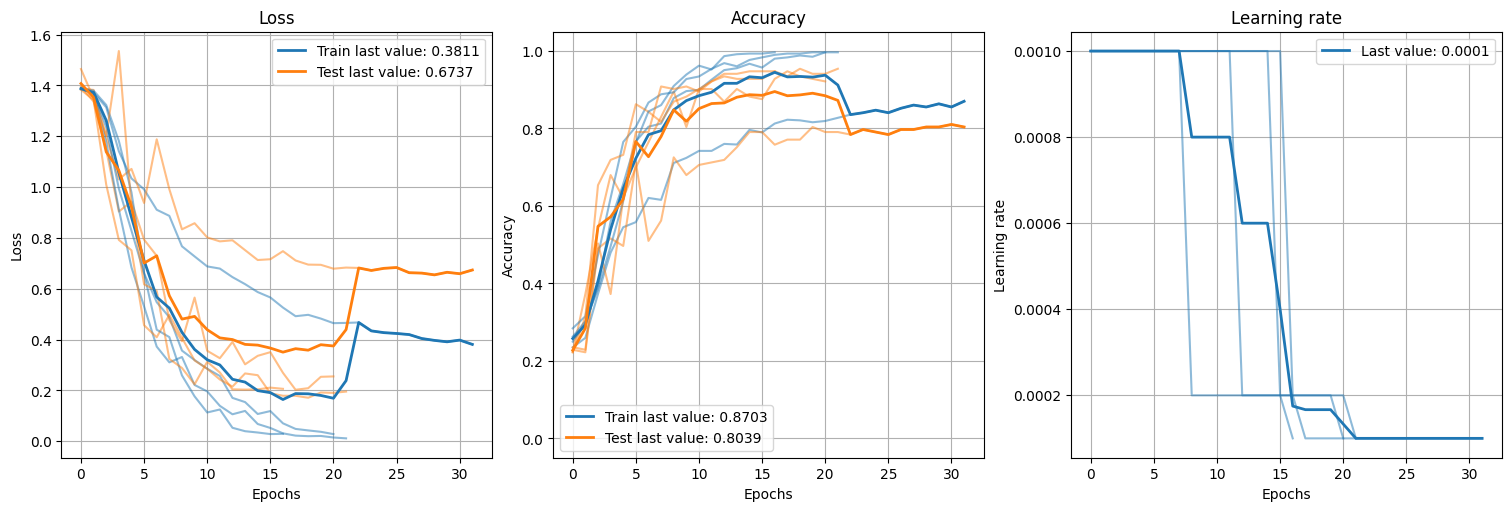

In [35]:
histories = []
for history in history_for_size:
    hist = history[1]
    histories.append(hist)

plot_history(
    histories,
    show_standard_deviation=False,
    show_average=True
)

plt.show()

There is already great improvement with using *32x32* in comparison to *12x12*. Resolution *64x64* provides reliable results. The best validation accuracy occured with *128x128*. Nevertheless, training and prediction was taking notable more time.
It must therefore be weighed up whether this additional time expenditure is worth the improvement over *32x32* or *64x64*.
For higher resolution, accuracy and loss on validation data gets worse with accuracy and loss getting better at the same time. This can be an indicator for overfitting. Additionally, due to the fact that the gesture only takes up a small part of the overall image (1920x1080), with *256x256* there might be already no added value in comparison to *128x128*.